# Imports

In [2]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

# Configuraciones iniciales de algunas constantes

In [3]:
CATEGORIAS = 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'
# configurar de acuerdo a dónde bajaron los sets de imágenes
TRAIN_DIR = Path('train')
TEST_DIR = Path('test')
SIZE = 150

In [4]:
images_reader = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    #horizontal_flip=True,
    #vertical_flip=True,
)
  
READ_PARAMS = dict(
    class_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    classes=CATEGORIAS,  # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE),  # para que corra más rápido, vamos a achicar las imágenes
    color_mode="rgb",  # queremos trabajar con las imágenes a color
)

In [27]:
import os
import shutil
import random

def dividir_train_validation_existente(carpeta_train, carpeta_validation, porcentaje_validacion=0.2):

    if not os.path.exists(carpeta_validation):
        os.makedirs(carpeta_validation)

    for categoria in os.listdir(carpeta_train):
        ruta_categoria_train = os.path.join(carpeta_train, categoria)
        
        if os.path.isdir(ruta_categoria_train):
            imagenes = [img for img in os.listdir(ruta_categoria_train) if os.path.isfile(os.path.join(ruta_categoria_train, img))]
            
            random.shuffle(imagenes)

            num_validacion = int(len(imagenes) * porcentaje_validacion)
            
            ruta_categoria_validation = os.path.join(carpeta_validation, categoria)
            if not os.path.exists(ruta_categoria_validation):
                os.makedirs(ruta_categoria_validation)

            for i in range(num_validacion):
                imagen = imagenes[i]
                ruta_imagen = os.path.join(ruta_categoria_train, imagen)
                shutil.move(ruta_imagen, os.path.join(ruta_categoria_validation, imagen))

    print("División completada: 20% de las imágenes movidas a validation.")

carpeta_train = 'train'
carpeta_validation = 'validation'

dividir_train_validation_existente(carpeta_train, carpeta_validation)


División completada: 20% de las imágenes movidas a validation.


In [31]:
VALIDATION_DIR='validation'

# Obtenemos los conjuntos de train y validation

In [32]:
import numpy as np
from keras.preprocessing import image

def load_test_images(test_dir):
    test_images = []
    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)
        img = image.load_img(img_path, target_size=(SIZE, SIZE))
        img_array = image.img_to_array(img) / 255.0
        test_images.append(img_array)
    return np.array(test_images)
  
test_images = load_test_images("test")

In [33]:
from keras.preprocessing import image_dataset_from_directory

train = images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS)
# validation = image_dataset_from_directory(VALIDATION_DIR, labels=None, label_mode=None, image_size=(SIZE, SIZE), shuffle=True)
validation = images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS)

# def normalizar_imagen(imagen):
#     return imagen / 255.0

# validation = validation.map(normalizar_imagen)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [34]:
# Para mostrar algunas imagenes del dataset
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(CATEGORIAS[np.argmax(labels[i])])
        plt.axis("off")

# def sample_images_test(dataset):
#     for imagen in dataset.take(1):
#         plt.figure(figsize=(10, 10))
#         for i in range(9):
#             plt.subplot(3, 3, i + 1)
#             plt.imshow(imagen[i].numpy())
#             plt.axis("off")
#         plt.show()

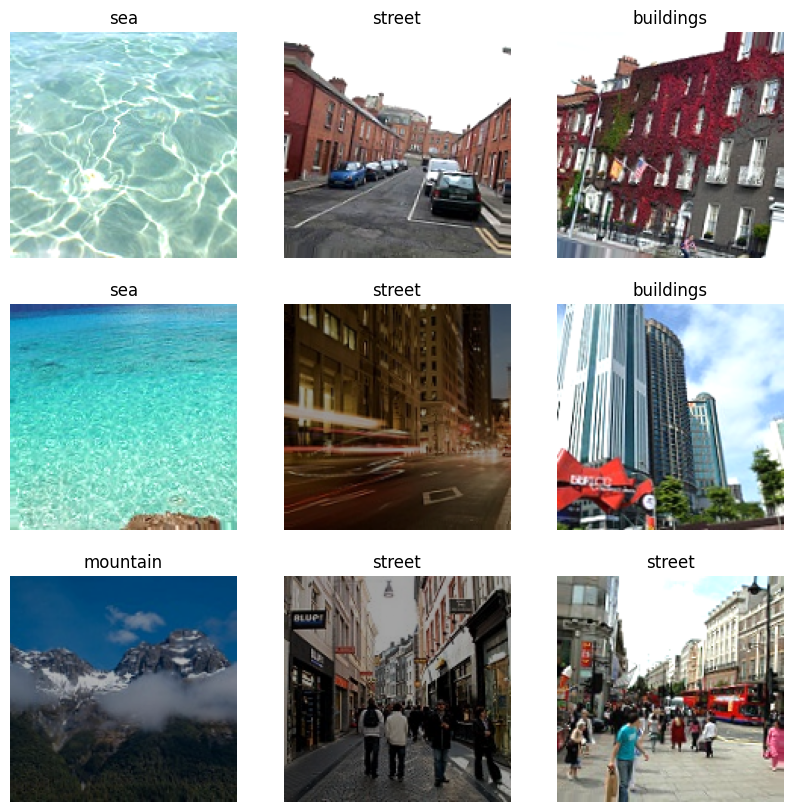

In [35]:
sample_images(train)

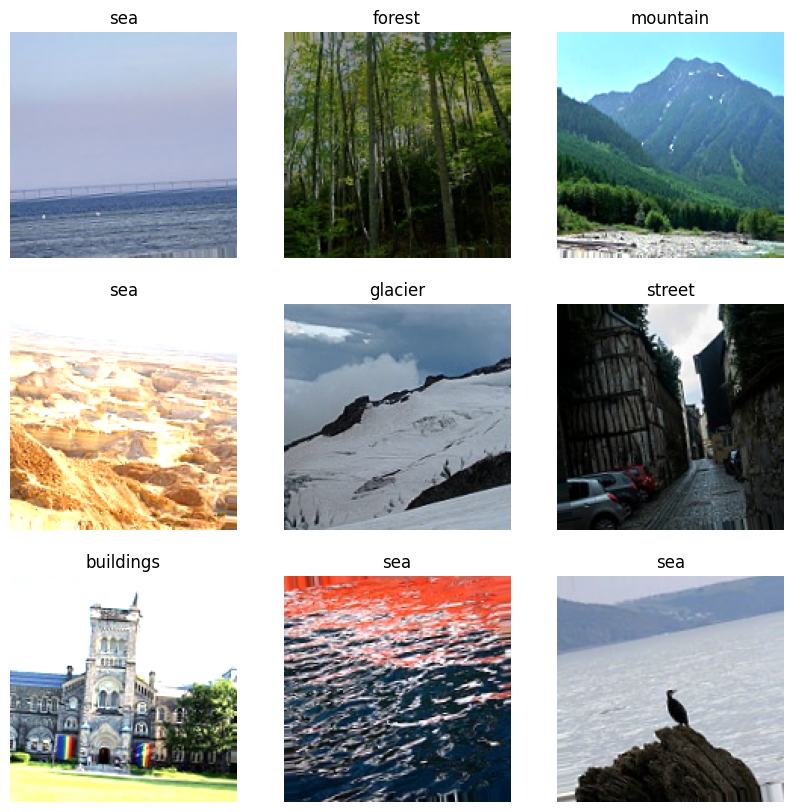

In [36]:
sample_images(validation)

# Análisis exploratorio del conjunto de datos

1. *Volumetría de los datos y distribución de las variables a predecir:*
   El conjunto de datos cuenta con un total de 14,034 imágenes, distribuidas en 6 categorías, de la siguiente manera:

   - *Buildings*: 2,191 imágenes (15.6%)
   - *Forest*: 2,271 imágenes (16.2%)
   - *Glacier*: 2,404 imágenes (17.1%)
   - *Mountain*: 2,512 imágenes (17.9%)
   - *Sea*: 2,274 imágenes (16.2%)
   - *Street*: 2,382 imágenes (17.0%)

   Las categorías están relativamente balanceadas, con diferencias menores en el número de imágenes entre clases. Ninguna categoría domina el conjunto de datos, lo que favorece el entrenamiento de un modelo equilibrado. Esto implica que no sería necesario realizar ajustes significativos para balancear las clases en este punto.

2. *Estructura y tipo de las imágenes:*
   - Las imágenes tienen un tamaño de *150x150 píxeles*.
   - El formato de las imágenes es JPG.
   - Las imágenes pertenecen a paisajes y escenas específicas de categorías bien diferenciadas, como edificios, naturaleza, y calles.



C:\Users\ignac\AppData\Local\Temp\ipykernel_30284\2824261227.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categorias, y=cantidades, palette='viridis')


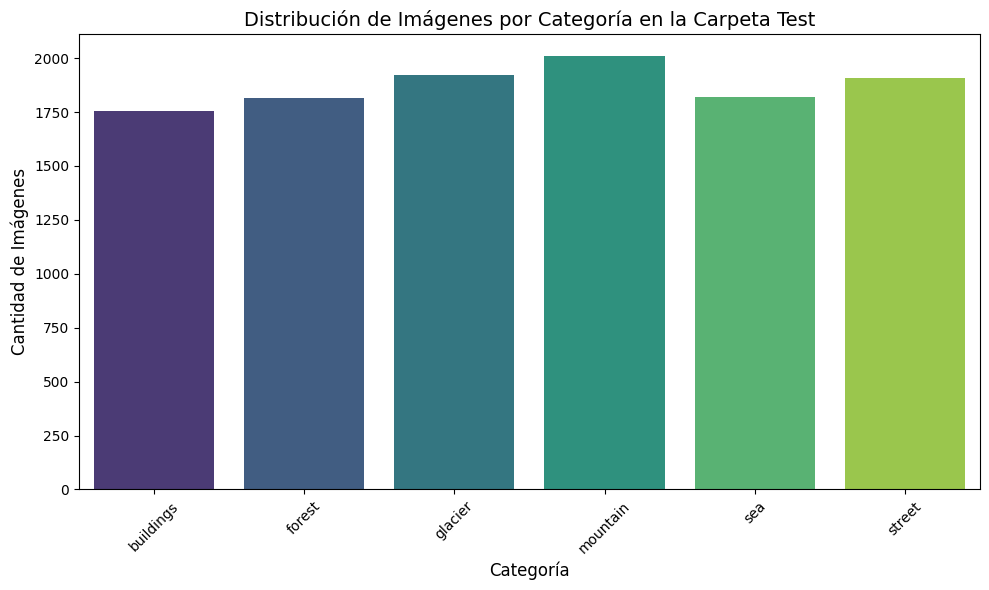

In [37]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def contar_imagenes_por_categoria(carpeta_train):
    conteo_categorias = {}

    for categoria in os.listdir(carpeta_train):
        ruta_categoria = os.path.join(carpeta_train, categoria)

        if os.path.isdir(ruta_categoria):
            cantidad_imagenes = len([img for img in os.listdir(ruta_categoria) if os.path.isfile(os.path.join(ruta_categoria, img))])
            conteo_categorias[categoria] = cantidad_imagenes

    return conteo_categorias

def graficar_distribucion(conteo_categorias):
    categorias = list(conteo_categorias.keys())
    cantidades = list(conteo_categorias.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=categorias, y=cantidades, palette='viridis')


    plt.title('Distribución de Imágenes por Categoría en la Carpeta Test', fontsize=14)
    plt.xlabel('Categoría', fontsize=12)
    plt.ylabel('Cantidad de Imágenes', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

conteo_categorias = contar_imagenes_por_categoria(TRAIN_DIR)

graficar_distribucion(conteo_categorias)

# Modelado

## Empezamos a trabajar con las redes neuronales

In [38]:
# el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
input_shape = (SIZE, SIZE, 3)

In [40]:
# MLP simple
model = Sequential([
    Input(input_shape),
    
    Flatten(),

    Dense(500, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CATEGORIAS), activation='softmax'),
])



In [11]:
# Convolucional
model = Sequential([
    Input(input_shape),

    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CATEGORIAS), activation='softmax'),
])

In [12]:
# Convolucional usando convoluciones ya entrenadas de VGG16
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    
    Dense(len(CATEGORIAS), activation='softmax'),
])

In [41]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 500)            │    33,750,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         3,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,753,506 (128.76 MB)

 Trainable params: 33,753,506 (128.76 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

In [43]:
history = model.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

c:\ML\TP_2_ML_Bellotti_Lopez_Trinchieri\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 170s 483ms/step - accuracy: 0.1852 - loss: 2.7842 - val_accuracy: 0.1740 - val_loss: 1.8151
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 126s 360ms/step - accuracy: 0.1852 - loss: 1.9609 - val_accuracy: 0.2678 - val_loss: 1.7584
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 145s 414ms/step - accuracy: 0.2076 - loss: 1.8791 - val_accuracy: 0.2571 - val_loss: 1.7118
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 143s 408ms/step - accuracy: 0.2363 - loss: 1.8126 - val_accuracy: 0.2471 - val_loss: 1.6499
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 139s 396ms/step - accuracy: 0.2352 - loss: 1.7727 - val_accuracy: 0.3178 - val_loss: 1.6575


Vemos el accuracy de ambos conjuntos, tanto train como validation, durante todo el proceso

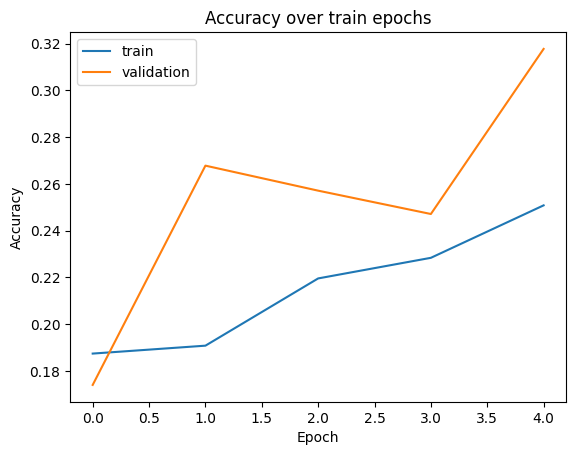

In [44]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Elegimos la que consideremos como la mejor epoca y nos quedamos con ese conjunto de pesos

In [45]:
BEST_EPOCH = 4
model.set_weights(model_weights_at_epochs[BEST_EPOCH])

Ahora analizamos el error de ambos conjuntos para sacar nuestras propias conclusiones

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
######################### train #########################
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
Accuracy: 0.3138302609315166


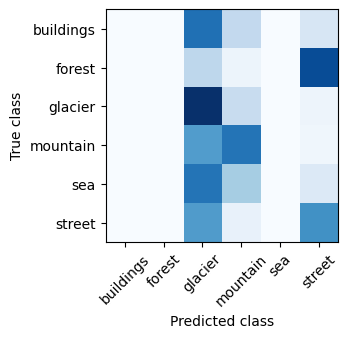

######################### validation #########################
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Accuracy: 0.32072779165180165


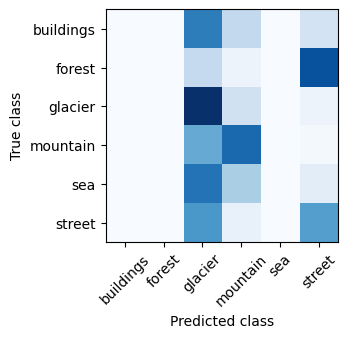

In [48]:
datasets = (
    ('train', images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS, batch_size=-1)),
    ('validation', images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS, batch_size=-1)),
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    batch_images, batch_labels = next(dataset)
    
    # super importante: usamos argmax para convertir cosas de este formato:
    # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
    # a este formato (donde tenemos el índice de la clase que tiene número más alto):
    # [1, 0, 0, 2]
    predictions = np.argmax(model.predict(batch_images), axis=-1)
    labels = np.argmax(batch_labels, axis=-1)
    
    print('Accuracy:', accuracy_score(labels, predictions))

    # graficamos la confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1, 2, 3, 4, 5], CATEGORIAS, rotation=45)
    plt.yticks([0, 1, 2, 3, 4, 5], CATEGORIAS)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

## Ahora probaremos con nuestras propias imágenes!

In [ ]:
from IPython.display import Image, display


def show_and_predict(image_path):
    image_array = img_to_array(load_img(image_path, target_size=(SIZE, SIZE)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = model.predict(inputs)
    display(Image(image_path, width=500))
    print("Prediction:", CATEGORIAS[np.argmax(predictions)])
    print("Prediction detail:", predictions)
show_and_predict("./test/20060.jpg")

In [75]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

CATEGORIA2 = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
SIZE = 150

def predict_images_from_directory(directory):
    results = [] 
    images = [] 

    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)

        if image_name.endswith(".jpg"):
            image_array = img_to_array(load_img(image_path, target_size=(SIZE, SIZE)))
            images.append(image_array)

    inputs = np.array(images) / 255.0  

    predictions = model.predict(inputs)

    for i, image_name in enumerate(os.listdir(directory)):
        if image_name.endswith(".jpg"):
            predicted_class = CATEGORIA2[np.argmax(predictions[i])]
            results.append([image_name, predicted_class])
    
    df = pd.DataFrame(results, columns=["ID", "Label"])
    df.to_csv("predicciones.csv", index=False)
    print("Predicciones guardadas en 'predicciones.csv'")

predict_images_from_directory('test')


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Predicciones guardadas en 'predicciones.csv'


# Conclusiones